# Projet 7 - Prédictions

In [1]:
# Librairies de base
import pandas as pd
print("pandas version:", pd.__version__)
import numpy as np
print("numpy version:", np.__version__)
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version:", matplotlib.__version__)

# MLFlow
import mlflow
from mlflow import MlflowClient
from mlflow.tracking import MlflowClient
print("mlflow version:", mlflow.__version__)

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,\
f1_score, roc_auc_score, roc_curve, fbeta_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
print("sklearn version:", sklearn.__version__)

# Modèles de classification
import lightgbm as lgb
print("lightgbm version:", lgb.__version__)
import catboost
from catboost import CatBoostClassifier
print("catboost version:", catboost.__version__)
import xgboost
from xgboost import XGBClassifier
print("xgboost version:", xgboost.__version__)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Autres
import shap # Feature importance
print("shap version:", shap.__version__)

pandas version: 2.2.2
numpy version: 1.26.4
matplotlib version: 3.8.4
mlflow version: 2.14.2
sklearn version: 1.5.1
lightgbm version: 4.4.0
catboost version: 1.2.5
xgboost version: 2.0.3
shap version: 0.45.1


C:\Users\coren\anaconda3\envs\P7essai1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Objectifs :
    - minimiser les faux négatifs (métrique = recall le plus élevé possible)
    - minimiser les faux positifs (métrique = precision le plus élevé possible)
- Déséquilibres dans le jeu de données : trop de bons clients (0) par rapport aux mauvais clients (1) --> utiliser l'argument class_weight pour résoudre le pb ds la mise en place des modèles

In [2]:
# Création de l'expérience MLFlow

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")
mlflow.set_tracking_uri("http://127.0.0.1:8080")
all_experiments = client.search_experiments()
print(all_experiments)

# Provide an Experiment description that will appear in the UI
#experiment_description = ("Classification des clients projet 7")

# Tag de l'expérience
#experiment_tags = {
#    "project_name": "Projet_7",
#    "mlflow.note.content": experiment_description,
#}

# Create the Experiment, providing a unique name
#projet_7_experiment = client.create_experiment(
#    name="Projet_7", tags=experiment_tags
#)

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
projet_7_experiment_current = mlflow.set_experiment("Projet_7")
mlflow.set_experiment("Projet_7")
# Define an artifact path that the model will be saved to.
artifact_path = "Projet_7"


[<Experiment: artifact_location='mlflow-artifacts:/445817929057729288', creation_time=1720791165501, experiment_id='445817929057729288', last_update_time=1720791165501, lifecycle_stage='active', name='Projet_7', tags={'mlflow.note.content': 'Classification des clients projet 7',
 'project_name': 'Projet_7'}>, <Experiment: artifact_location='mlflow-artifacts:/181467598177086032', creation_time=1720684342295, experiment_id='181467598177086032', last_update_time=1720684342295, lifecycle_stage='active', name='Apple_Models', tags={'mlflow.note.content': 'This is the grocery forecasting project. This '
                        'experiment contains the produce models for apples.',
 'project_name': 'grocery-forecasting',
 'project_quarter': 'Q3-2023',
 'store_dept': 'produce',
 'team': 'stores-ml'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1720645090927, experiment_id='0', last_update_time=1720645090927, lifecycle_stage='active', name='Default', tags={}>]


## Préparation des données

In [3]:
# Importation de la data

application_train_preprocessed = pd.read_csv("../data/application_train_preprocessed.csv")

In [4]:
# Split train/test

X = application_train_preprocessed.drop('TARGET', axis=1)
y = application_train_preprocessed['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
 # Extraction du nom des variables
features = list(X.columns)

# Imputation valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Normalisation avec MinMaxScaler, plus adapté que Standard Scaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (215257, 241)
Testing data shape:  (92254, 241)


## Mise en place des fonctions modèle et résultats

In [6]:
f1_beta_scorer = make_scorer(fbeta_score, beta=2)

# Modèle
def entrainementModeleAvecCV(modele, arguments_modele, param_grid):
    modele = modele(**arguments_modele) # argument class_weight pour gérer déséquilibre des données

    """CROSS VALIDATION"""
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=modele,
                               param_grid=param_grid,
                               scoring=f1_beta_scorer,
                               cv=cv,
                               verbose=0,
                               n_jobs=8)

    # Entraînement de la cross validation
    grid_search.fit(X_train, y_train)

    print("Meilleurs paramètres trouvés :", grid_search.best_params_)
    print("Meilleur score F1-bêta :", grid_search.best_score_)

    meilleurModele = grid_search.best_estimator_
    
    """PREDICTIONS"""
    model_pred_proba = meilleurModele.predict_proba(X_test)[:, 1]
    model_pred = meilleurModele.predict(X_test)

    return {
        "modele":modele,
        "hyperparametres": meilleurModele,
        "model_pred_proba": model_pred_proba,
        "model_pred": model_pred
    }
    
# Entrainement sur le jeu de train
#log_reg.fit(X_train, y_train)

In [10]:
def affichageResultatsModele(model_dict):

    model_pred = model_dict["model_pred"]
    model_pred_proba = model_dict["model_pred_proba"]
    hyperparametres = model_dict["hyperparametres"]
    hyperparametres_dict = model_dict["hyperparametres"].get_params()
    
    """MATRICE DE CONFUSION"""
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, model_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Création de la matrice de confusion avec les labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bons clients', 'Mauvais clients'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='')
        
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()

    """METRIQUES"""
    precision = round(precision_score(y_test, model_pred), 4)
    recall = round(recall_score(y_test, model_pred), 4)
    f1 = round(f1_score(y_test, model_pred), 4)
    roc_auc = round(roc_auc_score(y_test, model_pred_proba), 4)
    f1_beta = round(fbeta_score(y_test, model_pred, beta = 10), 4)
    
    metrics = {"precision":precision, "recall":recall, "f1":f1, "f1_beta":f1_beta, "roc_auc":roc_auc}
    display(metrics)

    """FEATURE IMPORTANCE GLOBALE"""
    #explainer = shap.Explainer(hyperparametres, X_train)
    #shap_values = explainer(X_test)
    #shap.summary_plot(shap_values, X_test)

    """ENVOI DANS LE MLFLOW"""
    with mlflow.start_run() as run:
        mlflow.set_tag("model_name", type(hyperparametres).__name__) #nom du modèle
        mlflow.log_params(hyperparametres_dict) #hyperparametres du modèle
        mlflow.log_metrics(metrics) #metriques du modele    
        mlflow.sklearn.log_model(sk_model=hyperparametres, artifact_path="Projet_7")

In [8]:
# Importance locale des caractéristiques pour un échantillon

def featureImportanceLocale(model_dict, individu):
    hyperparametres = model_dict["hyperparametres"]
    shap.initjs()
    explainer = shap.Explainer(hyperparametres, X_train)
    shap_values = explainer(X_test)
    shap.force_plot(shap_values[0].base_values, shap_values[0].values, X_test.iloc[0], feature_names=features)

## Test de différents modèles

#### LogisticRegression

Meilleurs paramètres trouvés : {'C': 1, 'max_iter': 300}
Meilleur score F1-bêta : 0.4111151720737475


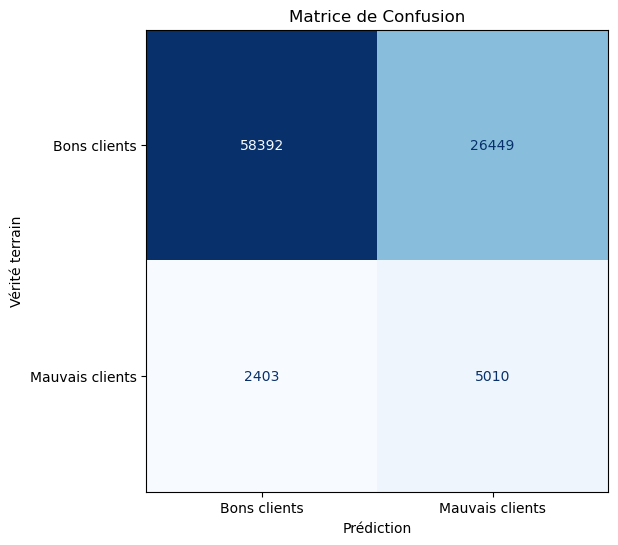

{'precision': 0.1593,
 'recall': 0.6758,
 'f1': 0.2578,
 'f1_beta': 0.6548,
 'roc_auc': 0.747}

In [11]:
arguments_modele={"class_weight":"balanced"}

param_grid = {
    "C": [0.1, 1, 10],
    "max_iter": [100, 200, 300]
}

LogisticRegression_entraine = entrainementModeleAvecCV(LogisticRegression, arguments_modele, param_grid)
affichageResultatsModele(LogisticRegression_entraine)
#featureImportanceLocale(LogisticRegression_entraine, 0)

#### LightGBM Classifier

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11949
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

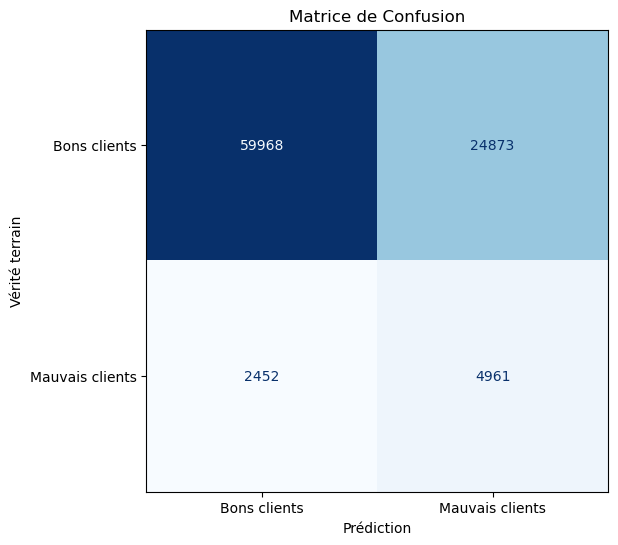

{'precision': 0.1663,
 'recall': 0.6692,
 'f1': 0.2664,
 'f1_beta': 0.6498,
 'roc_auc': 0.7554}

In [12]:
arguments_modele={"class_weight":"balanced"}

param_grid = {
    "num_leaves":[31, 63, 127],
    "n_estimators":[100,200,300],
    "max_depth":[3,5,7]
}

LGBMClassifier_entraine = entrainementModeleAvecCV(lgb.LGBMClassifier, arguments_modele, param_grid)
affichageResultatsModele(LGBMClassifier_entraine)
#featureImportanceLocale(LGBMClassifier_entraine, 0)

Essayer le check_additivity=False voir si ça passe

#### Catboost Classifier

0:	learn: 0.6862895	total: 168ms	remaining: 1m 7s
1:	learn: 0.6804100	total: 205ms	remaining: 40.9s
2:	learn: 0.6752948	total: 248ms	remaining: 32.8s
3:	learn: 0.6705574	total: 299ms	remaining: 29.6s
4:	learn: 0.6657140	total: 352ms	remaining: 27.8s
5:	learn: 0.6616736	total: 410ms	remaining: 27s
6:	learn: 0.6576748	total: 469ms	remaining: 26.3s
7:	learn: 0.6541724	total: 534ms	remaining: 26.2s
8:	learn: 0.6511024	total: 604ms	remaining: 26.2s
9:	learn: 0.6484063	total: 664ms	remaining: 25.9s
10:	learn: 0.6456535	total: 728ms	remaining: 25.7s
11:	learn: 0.6431840	total: 782ms	remaining: 25.3s
12:	learn: 0.6407671	total: 840ms	remaining: 25s
13:	learn: 0.6386511	total: 888ms	remaining: 24.5s
14:	learn: 0.6366159	total: 940ms	remaining: 24.1s
15:	learn: 0.6345720	total: 994ms	remaining: 23.9s
16:	learn: 0.6329837	total: 1.05s	remaining: 23.6s
17:	learn: 0.6313145	total: 1.09s	remaining: 23.2s
18:	learn: 0.6297866	total: 1.15s	remaining: 23s
19:	learn: 0.6282683	total: 1.19s	remaining: 22

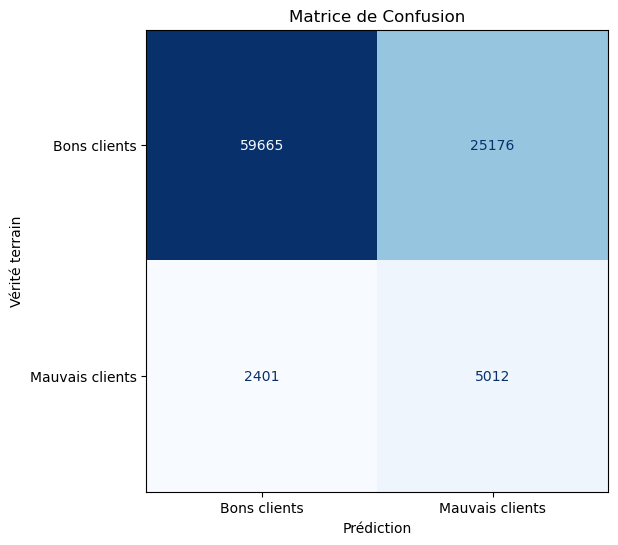

{'precision': 0.166,
 'recall': 0.6761,
 'f1': 0.2666,
 'f1_beta': 0.6562,
 'roc_auc': 0.7585}

In [13]:
arguments_modele={}

param_grid = {
    'depth': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400],
    'l2_leaf_reg':[1,3,5],
    "auto_class_weights":["Balanced"]
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(CatBoostClassifier, arguments_modele, param_grid)
affichageResultatsModele(CatBoostClassifier_entraine)
#featureImportanceLocale(CatBoostClassifier_entraine, 0)

#### XGBoost

Meilleurs paramètres trouvés : {'gamma': 0, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 11.362566046404778}
Meilleur score F1-bêta : 0.4162600194857783


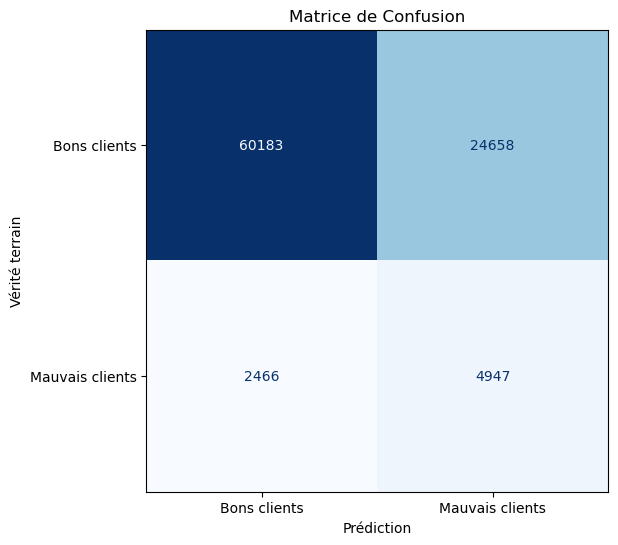

{'precision': 0.1671,
 'recall': 0.6673,
 'f1': 0.2673,
 'f1_beta': 0.6481,
 'roc_auc': 0.7551}

In [14]:
# XGBClassifier n'a pas de fonctionnalite intégrée pour équilibrer les classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weights_dict[1] / class_weights_dict[0]

arguments_modele={}

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'gamma':[0, 0.1, 0.2]
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(XGBClassifier, arguments_modele, param_grid)
affichageResultatsModele(CatBoostClassifier_entraine)
#featureImportanceLocale(CatBoostClassifier_entraine, 0)

#### RandomForest

Meilleurs paramètres trouvés : {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 300}
Meilleur score F1-bêta : 0.3943016076409037


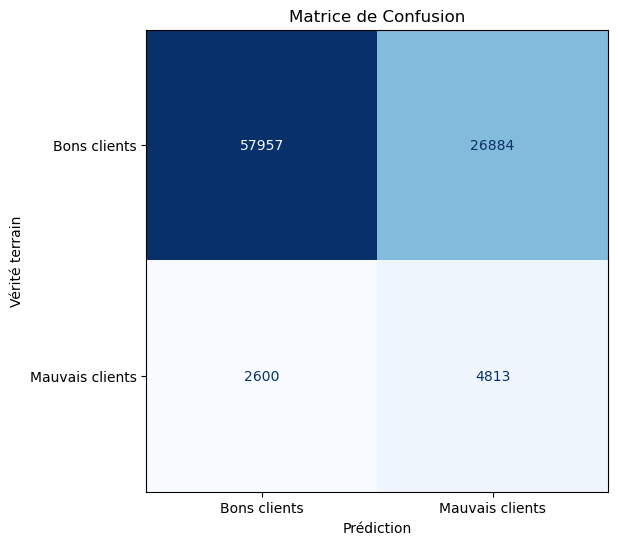

{'precision': 0.1518,
 'recall': 0.6493,
 'f1': 0.2461,
 'f1_beta': 0.6289,
 'roc_auc': 0.7258}

In [16]:
arguments_modele={"class_weight":"balanced"}

param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[3,5,7],
    "min_samples_split":[2,5,8],
    "min_samples_leaf":[1,2,3]
}

RandomForestClassifier_entraine = entrainementModeleAvecCV(RandomForestClassifier, arguments_modele, param_grid)
affichageResultatsModele(RandomForestClassifier_entraine)
#featureImportanceLocale(RandomForestClassifier_entraine, 0)